## 8. Try to build your own Canny edge detector (not the one that is called directly from OpenCV) and detect the edges in the image.  

### Canny edge detector (from scratch)

This section implements the full Canny pipeline without calling OpenCV's `Canny`:

1) Smooth image with a Gaussian to reduce noise
2) Compute x/y derivatives (Sobel)
3) Gradient magnitude and orientation
4) Non-maximum suppression to thin edges
5) Double thresholding (low/high)
6) Edge tracking by hysteresis (linking weak to strong)


In [1]:
# Imports and small utilities
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
# Common: 2D convolution (single-channel)

def conv2d(image, kernel, padding='reflect'):
    img = image.astype(np.float32)
    ker = kernel.astype(np.float32) 
    kh, kw = ker.shape
    ph, pw = kh//2, kw//2
    if padding == 'reflect':
        img_p = np.pad(img, ((ph, ph), (pw, pw)), mode='reflect')
    elif padding == 'edge':
        img_p = np.pad(img, ((ph, ph), (pw, pw)), mode='edge')
    else:
        img_p = np.pad(img, ((ph, ph), (pw, pw)), mode='constant')
    H, W = img.shape
    out = np.zeros_like(img, dtype=np.float32)
    for i in range(H):
        for j in range(W):
            region = img_p[i:i+kh, j:j+kw]
            out[i, j] = np.sum(region * ker)
    return out

In [3]:
# Data setup (plot)
import matplotlib.image as mpimg
from pathlib import Path

# Set this to a local image path to use a real image;
image_path = r'./source/QuebecBridge_EleView.jpg'  # e.g., r"c:\\Users\\1213123\\Pictures\\test.jpg"

def load_image(image_path):
    if image_path and Path(image_path).exists():
        img = mpimg.imread(image_path)
        return img
    
def to_grayscale(img):
    """Convert RGB or RGBA image to grayscale float32 [0,1]."""
    img = np.asarray(img)
    if img.ndim == 2:
        g = img.astype(np.float32)
        # Normalize if likely 0..255
        if g.max() > 1.5:
            g = g / 255.0
        return g
    if img.shape[-1] == 4:  # drop alpha
        img = img[..., :3]
    # BT.709 luma weights
    w = np.array([0.2126, 0.7152, 0.0722], dtype=np.float32)
    g = np.tensordot(img.astype(np.float32), w, axes=([-1],[0]))
    if g.max() > 1.5:
        g = g / 255.0
    return g

def imshow_grid(images, titles=None, cmap='gray', ncols=3, figsize=(12, 8)):
    images = list(images)
    n = len(images)
    ncols = min(ncols, n) if n>0 else 1
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        ax = plt.subplot(nrows, ncols, i+1)
        if img.ndim == 2:
            ax.imshow(img, cmap=cmap)
        else:
            ax.imshow(img)
        if titles and i < len(titles):
            ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()


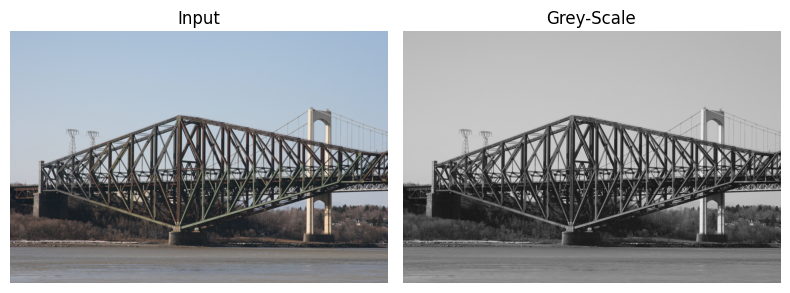

In [4]:
img = load_image(image_path)
g_pre = to_grayscale(img)
imshow_grid([img, g_pre],
            titles=['Input','Grey-Scale'], ncols=2, figsize=(8,4))

In [5]:
# Step 0: Gaussian smoothing (function + run)
import numpy as np

def gaussian_kernel(size=5, sigma=1.4):
    assert size % 2 == 1, 'Kernel size must be odd'
    k = size // 2
    x = np.arange(-k, k+1)
    y = np.arange(-k, k+1)
    X, Y = np.meshgrid(x, y)
    g = np.exp(-(X**2 + Y**2) / (2*sigma**2)).astype(np.float32)
    g /= g.sum()
    return g

def gaussian_blur(img, size=5, sigma=1.4):
    """Apply Gaussian smoothing using conv2d and a generated kernel."""
    gk = gaussian_kernel(size=size, sigma=sigma)
    return conv2d(img, gk, padding='reflect')


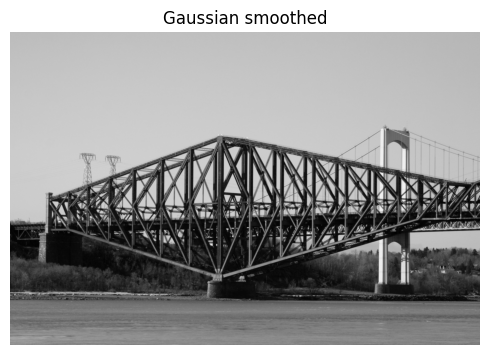

In [6]:
# run & plot
g0 = gaussian_blur(g_pre, size=5, sigma=1.4)
imshow_grid([g0], titles=['Gaussian smoothed'], ncols=1, figsize=(5,4))

In [7]:
# Step 1 run: Sobel derivatives (plot)
def sobel_derivatives(img):
    Sx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]], dtype=np.float32)
    Sy = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1,-2,-1]], dtype=np.float32)
    Ix = conv2d(img, Sx, padding='reflect')
    Iy = conv2d(img, Sy, padding='reflect')
    return Ix, Iy



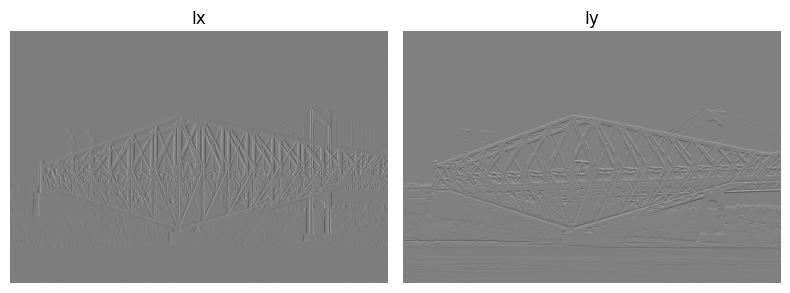

In [8]:
Ix, Iy = sobel_derivatives(g0)
imshow_grid([Ix, Iy], titles=['Ix','Iy'], ncols=2, figsize=(8,4))

In [9]:
# Step 2 run: Gradient magnitude and orientation (plot)
def gradient_magnitude_orientation(Ix, Iy, use_l2=True):
    if use_l2:
        mag = np.hypot(Ix, Iy).astype(np.float32)
    else:
        mag = (np.abs(Ix) + np.abs(Iy)).astype(np.float32)
    theta = np.degrees(np.arctan2(Iy, Ix)).astype(np.float32)  # -180..180
    return mag, theta


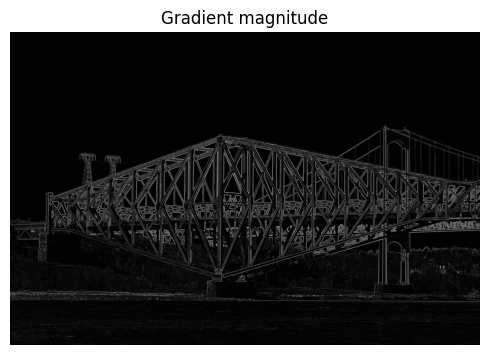

In [10]:
mag, theta = gradient_magnitude_orientation(Ix, Iy, use_l2=True)
imshow_grid([mag], titles=['Gradient magnitude'], ncols=1, figsize=(5,4))

In [11]:
# Step 3: Non-maximum suppression (function)
import numpy as np

def non_maximum_suppression(mag, theta):
    H, W = mag.shape
    Z = np.zeros((H, W), dtype=np.float32)
    angle = theta.copy()
    angle[angle < 0] += 180
    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 0.0
            r = 0.0
            a = angle[i, j]
            if (0 <= a < 22.5) or (157.5 <= a <= 180):
                q = mag[i, j+1]
                r = mag[i, j-1]
            elif (22.5 <= a < 67.5):
                q = mag[i+1, j-1]
                r = mag[i-1, j+1]
            elif (67.5 <= a < 112.5):
                q = mag[i+1, j]
                r = mag[i-1, j]
            else:
                q = mag[i-1, j-1]
                r = mag[i+1, j+1]
            if mag[i, j] >= q and mag[i, j] >= r:
                Z[i, j] = mag[i, j]
            else:
                Z[i, j] = 0.0
    return Z



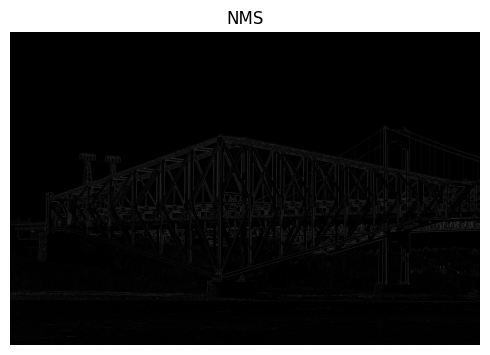

In [12]:
nms = non_maximum_suppression(mag, theta)
imshow_grid([nms], titles=['NMS'], ncols=1, figsize=(5,4))

In [13]:
# Step 4: Double thresholding (function)

def double_threshold(img, low_ratio=0.05, high_ratio=0.15):
    high = img.max() * high_ratio
    low = high * low_ratio
    strong = np.float32(1.0)
    weak = np.float32(0.5)
    res = np.zeros_like(img, dtype=np.float32)
    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img >= low) & (img < high))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    return res, weak, strong

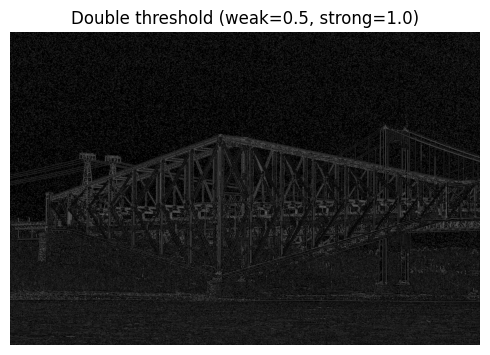

In [14]:
# Step 4 run: Double thresholding (plot)
dt, weak, strong = double_threshold(nms, low_ratio=0.05, high_ratio=0.15)
imshow_grid([dt], titles=['Double threshold (weak=0.5, strong=1.0)'], ncols=1, figsize=(5,4))

In [15]:
# Step 5: Edge tracking by hysteresis (function)

def hysteresis(img, weak, strong):
    H, W = img.shape
    out = img.copy()
    for i in range(1, H-1):
        for j in range(1, W-1):
            if out[i, j] == weak:
                local = out[i-1:i+2, j-1:j+2]
                if np.any(local == strong):
                    out[i, j] = strong
                else:
                    out[i, j] = 0.0
    # Second pass to propagate longer chains
    for i in range(1, H-1):
        for j in range(1, W-1):
            if out[i, j] == weak:
                local = out[i-1:i+2, j-1:j+2]
                if np.any(local == strong):
                    out[i, j] = strong
                else:
                    out[i, j] = 0.0
    return out

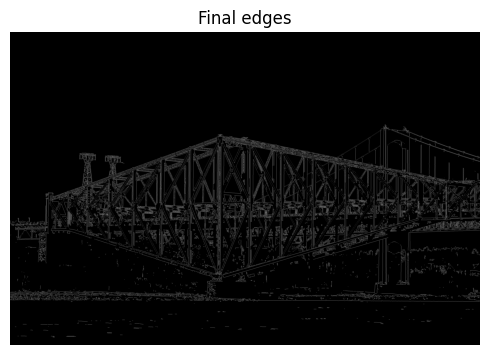

In [16]:
# Step 5 run: Hysteresis (plot)
edges = hysteresis(dt, weak, strong)
imshow_grid([edges], titles=['Final edges'], ncols=1, figsize=(5,4))

In [17]:
# Save final edges

plt.imsave('nms_edges.png', edges, cmap='gray')